In [126]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
import numpy as np

Projekt dotyczy klasteryzacji (grupowaniu) danych bez wcześniejszych etykiet (uczenie nienadzorowane).

Wykorzystane algorytmy to K-Means, hierarchiczny i DBSCAN.
Efektywność podziału na klastry oceniana jest za pomocą Silhouette Score.

In [127]:
#wczytanie danych
file_id = '15wAcMEE6PioszqgY4A1I339Fpb5jm6K_'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

#normalizacja danych
print("Liczba wierszy z brakującymi danymi")
print(df.isna().sum())
#usuwam wiersze z brakami
df_clean = df.dropna()
print("Liczba wierszy przed usunięciem: ",len(df))
print("Liczba wierszy po usunęciu: ",len(df_clean))
df = df_clean
#konwersja typów zmiennych (tylko w ramach normalizacji, nie będą wykorzystywane)
df["title"] = df["title"].astype("string")
df["artist"] = df["artist"].astype("string")
df["top genre"] = df["top genre"].astype("string")
df["added"] = pd.to_datetime(df["added"], format='%Y‑%m‑%d')
df["artist type"] = df["artist type"].astype("string")

#Teraz wybieram dwie cechy. Przeprowadzę klasteryzację przy użyciu algorytmów K-Means, hierarchicznego i DBSCAN.
#bpm - Beats Per Minute
#nrgy - How energetic the song is
df2 = DataFrame(df,columns=['bpm','nrgy'])

#standaryzacja danych
scaler = StandardScaler()
df2_std_array = scaler.fit_transform(df2)
df2_std = pd.DataFrame(df2_std_array, columns=df2.columns)  # konwersja na DataFrame

Liczba wierszy z brakującymi danymi
title            3
artist           3
top genre        3
year released    3
added            3
bpm              3
nrgy             3
dnce             3
dB               3
live             3
val              3
dur              3
acous            3
spch             3
pop              3
top year         3
artist type      3
dtype: int64
Liczba wierszy przed usunięciem:  1003
Liczba wierszy po usunęciu:  1000


In [129]:
#algorytm podziałowy
def f_kmeans(n):
    kmeans = KMeans(n_clusters=n).fit(df2_std)
    centroids = kmeans.cluster_centers_
    #print("Centroidy:")
    #print(centroids)
    plt.scatter(df2_std['bpm'], df2_std['nrgy'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
    plt.show()
    #silhouette score - ocena podziału
    score = silhouette_score(df2_std, kmeans.labels_, metric='euclidean')
    print(n,"clusters","silhouette_score =",score)
    return score

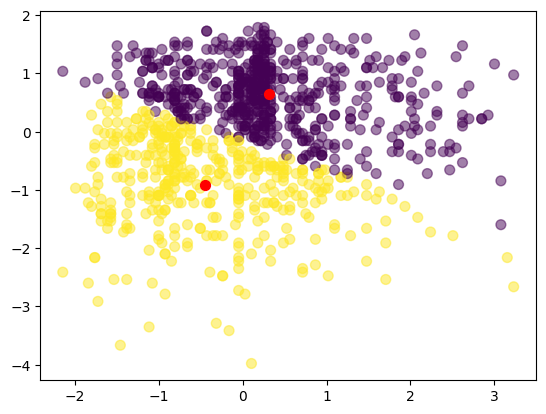

2 clusters silhouette_score = 0.35623375072046715


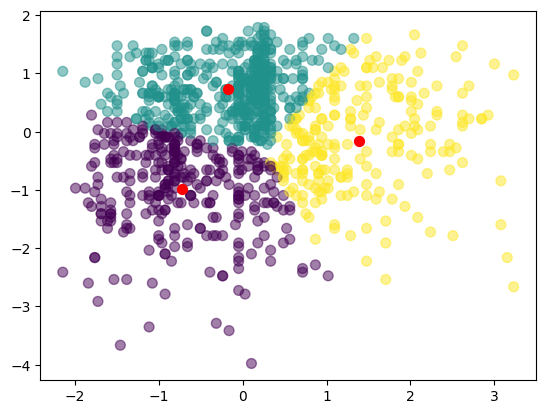

3 clusters silhouette_score = 0.3799521911420371


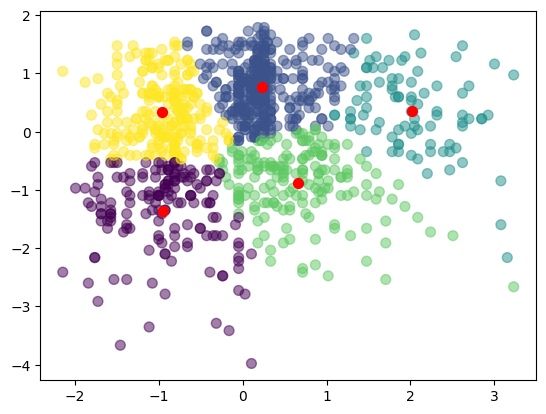

5 clusters silhouette_score = 0.3842940525861166
Najlepszym podziałem jest podział na 5 grup/y. Indeks Sillhouette podziału wynosi 0.3842940525861166


In [130]:
kmeans2 = f_kmeans(2)
kmeans3 = f_kmeans(3)
kmeans5 = f_kmeans(5)
scores = {kmeans2:"2",kmeans3:"3",kmeans5:"5"}
print("Najlepszym podziałem jest podział na",scores.get(max(scores)),"grup/y. Indeks Sillhouette podziału wynosi",max(scores))

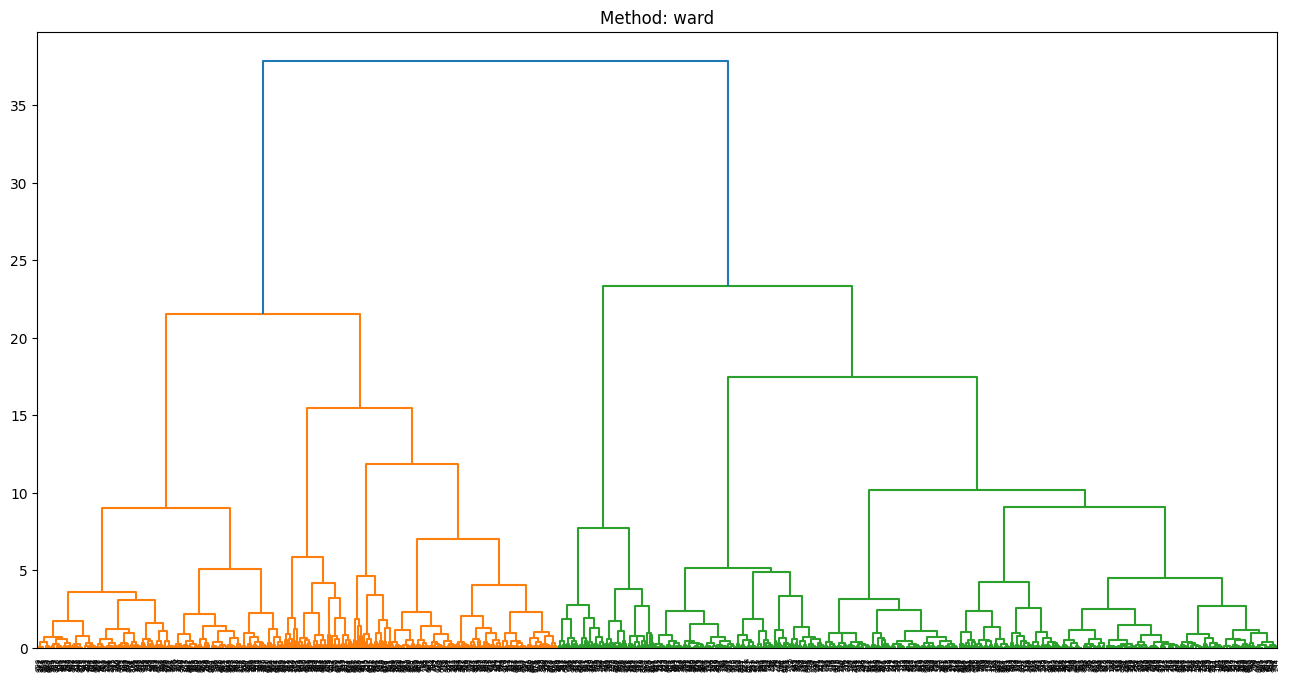

Silhouette score: 0.35235316519958565


In [131]:
#algorytm hierarchiczny
#porównam różne metody ustalając liczbę klastrów jako 2
#dla każdej metody obliczę silhouette score
plt.figure(figsize=(16, 8))
plt.title("Method: ward")
Z = shc.linkage(df2_std, method='ward')
dend = shc.dendrogram(Z)
plt.show()
labels = shc.fcluster(Z, t=2, criterion='maxclust')
score_ward = silhouette_score(df2_std, labels)
print("Silhouette score:", score_ward)

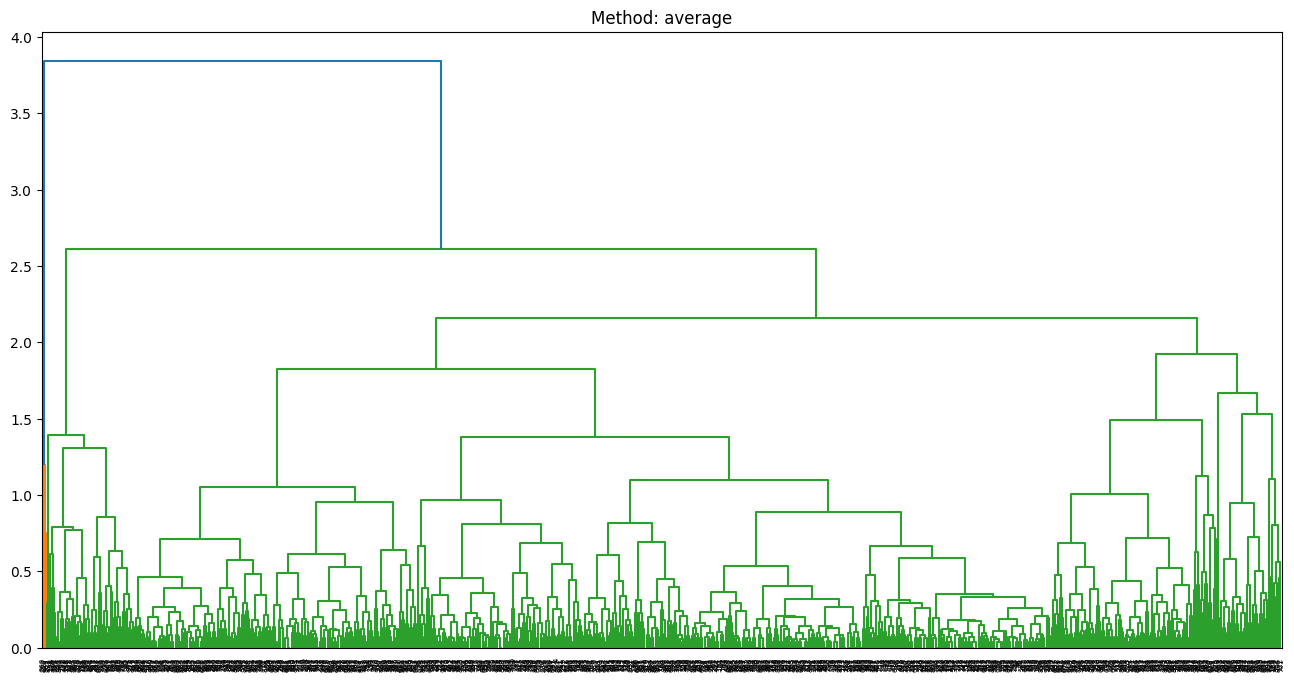

Silhouette score: 0.5121927624355298


In [132]:
plt.figure(figsize=(16, 8))
plt.title("Method: average")
Z = shc.linkage(df2_std, method='average')
dend2 = shc.dendrogram(Z)
plt.show()
labels = shc.fcluster(Z, t=2, criterion='maxclust')
score_average = silhouette_score(df2_std, labels)
print("Silhouette score:", score_average)

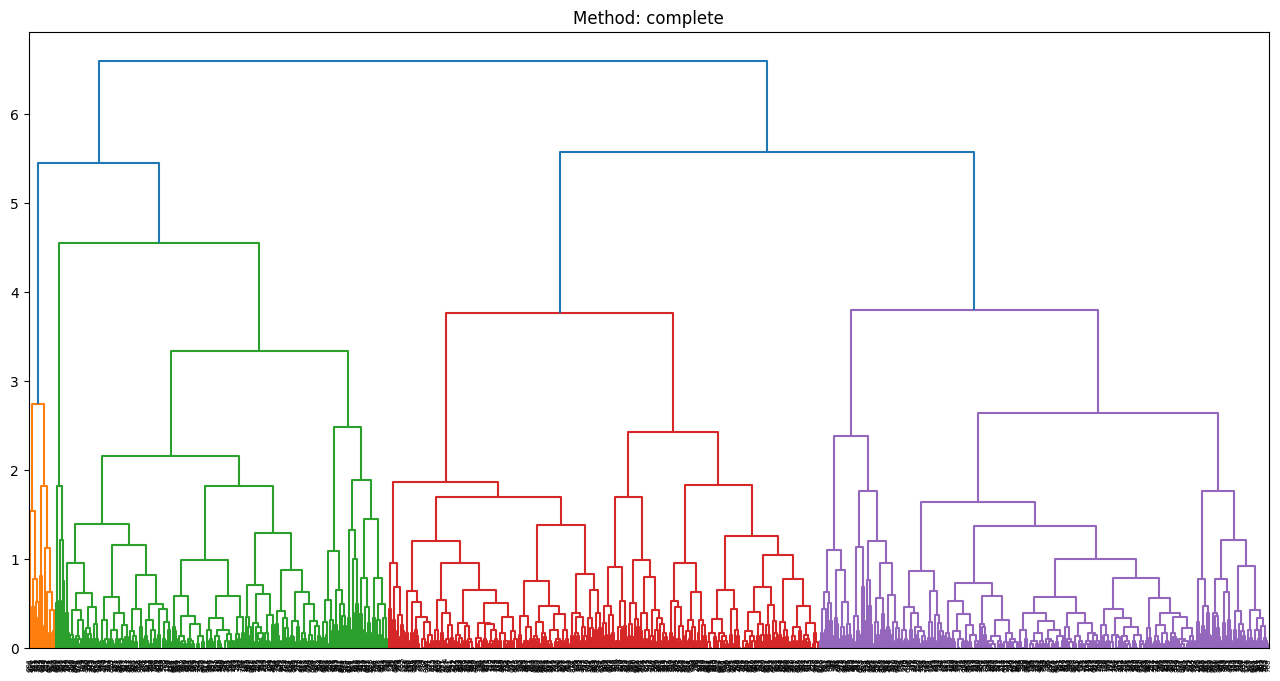

Silhouette score: 0.2158074290367717


In [133]:
plt.figure(figsize=(16, 8))
plt.title("Method: complete")
Z = shc.linkage(df2_std, method='complete')
dend3 = shc.dendrogram(Z)
plt.show()
labels = shc.fcluster(Z, t=2, criterion='maxclust')
score_complete = silhouette_score(df2_std, labels)
print("Silhouette score:", score_complete)

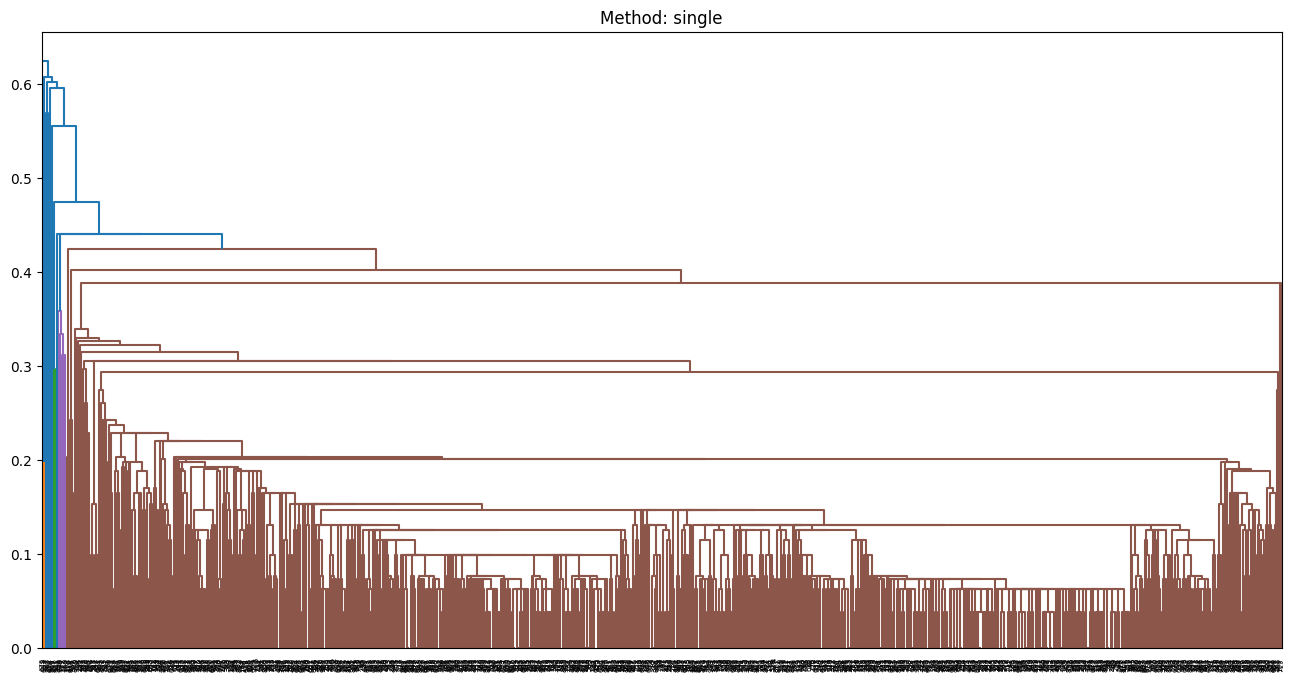

Silhouette score: 0.5376038753978921


In [134]:
plt.figure(figsize=(16, 8))
plt.title("Method: single")
Z = shc.linkage(df2_std, method='single')
dend4 = shc.dendrogram(Z)
plt.show()
labels = shc.fcluster(Z, t=2, criterion='maxclust')
score_single = silhouette_score(df2_std, labels)
print("Silhouette score:", score_single)

In [135]:
#Porównuję wyniki Silhouette score dla różnych metod algorytmu hierarchocznego
#Najwyższy wynik wskazuje metodę, która daje najbardziej zwarty i dobrze odseparowany podział danych
scores = {
    'ward': score_ward,
    'average': score_average,
    'complete': score_complete,
    'single': score_single
}
score_highest_name = max(scores, key=scores.get)
score_highest_value = scores[score_highest_name]
print(f"Największa wartość: {score_highest_value}, metoda: {score_highest_name}")

Największa wartość: 0.5376038753978921, metoda: single


In [136]:
#algorytm gęstościowy
def f_dbscan(var1, var2):
    dbscan = DBSCAN(eps = var1, min_samples = var2)
    model = dbscan.fit(df2_std)
    clusters = pd.DataFrame(model.fit_predict(df2_std), columns=["Cluster"])
    df2_std["Cluster"] = clusters
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df2_std['bpm'],df2_std['nrgy'],c=df2_std["Cluster"],s=50)
    title = "DBSCAN, eps={} min_samples={}".format(var1, var2)
    ax.set_title(title)
    ax.set_xlabel("bpm")
    ax.set_ylabel("nrgy")
    plt.colorbar(scatter)
    plt.show()

    #znalezione klastry
    labels = dbscan.fit_predict(df2_std)
    print("Etykiety (klastry) wykryte przez DBSAN (-1 to szum): ",np.unique(labels))

    #usuwam szum i obliczam Silhouette Score
    mask_clusters = labels != -1
    num_points_in_clusters = mask_clusters.sum()
    num_clusters = len(set(labels[mask_clusters])) - (1 if -1 in labels[mask_clusters] else 0)
    if num_points_in_clusters < 2 or num_clusters < 2:
        print("Za mało punktów w klastrach, nie można policzyć Silhouette Score")
    else:
        score = silhouette_score(df2.loc[mask_clusters, ['bpm','nrgy']], labels[mask_clusters])
        print("Silhouette Score:", score)

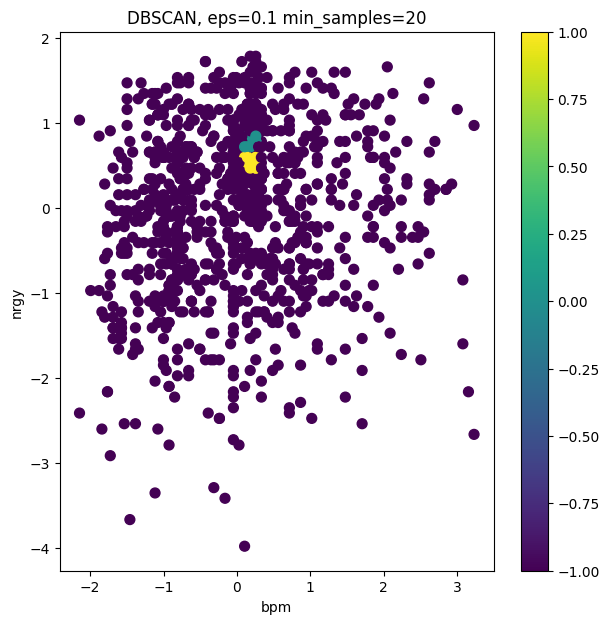

Etykiety (klastry) wykryte przez DBSAN (-1 to szum):  [-1  0  1]
Silhouette Score: 0.49316165018563085


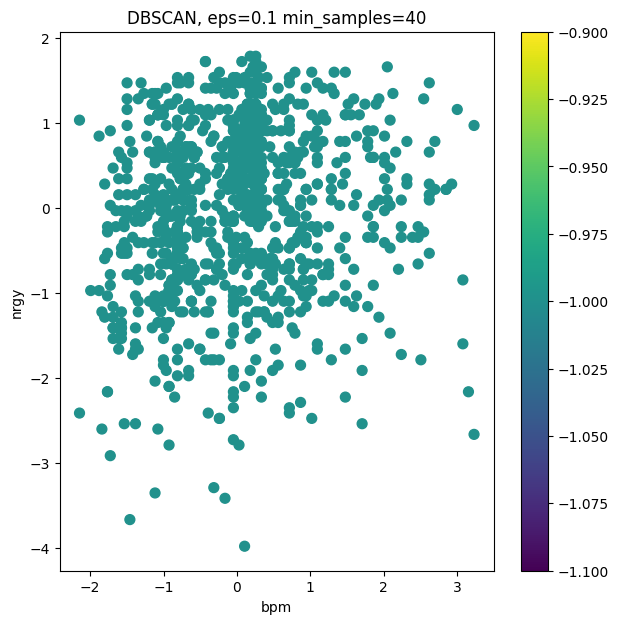

Etykiety (klastry) wykryte przez DBSAN (-1 to szum):  [-1]
Za mało punktów w klastrach, nie można policzyć Silhouette Score


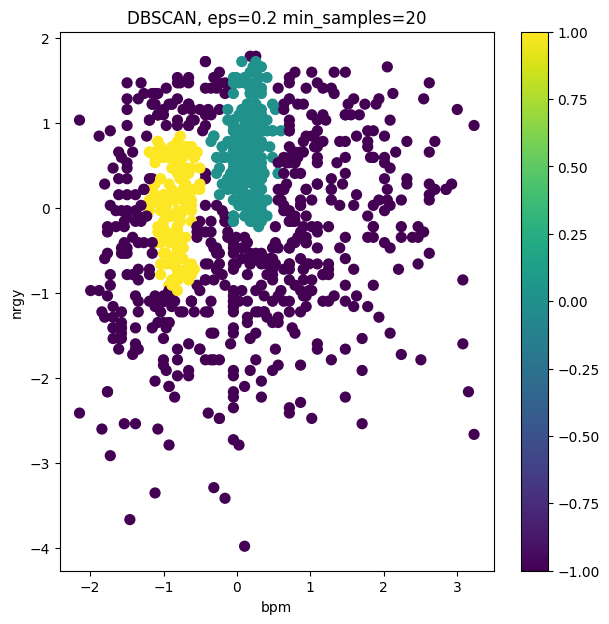

Etykiety (klastry) wykryte przez DBSAN (-1 to szum):  [-1  0  1]
Silhouette Score: 0.6198714412474725


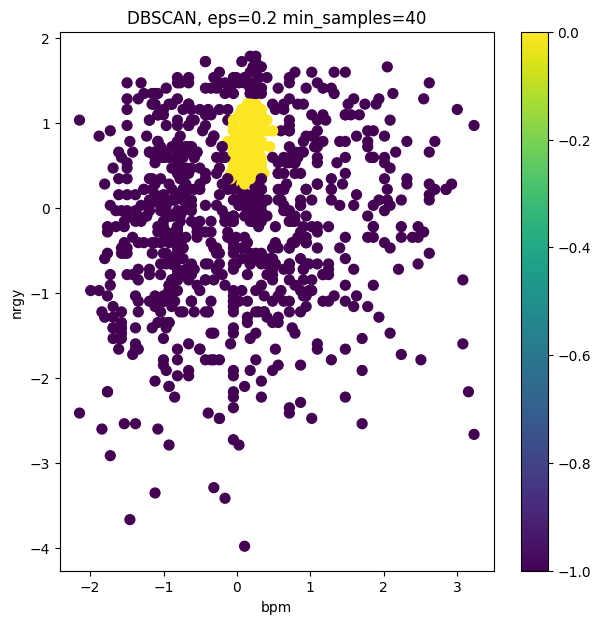

Etykiety (klastry) wykryte przez DBSAN (-1 to szum):  [-1  0]
Za mało punktów w klastrach, nie można policzyć Silhouette Score


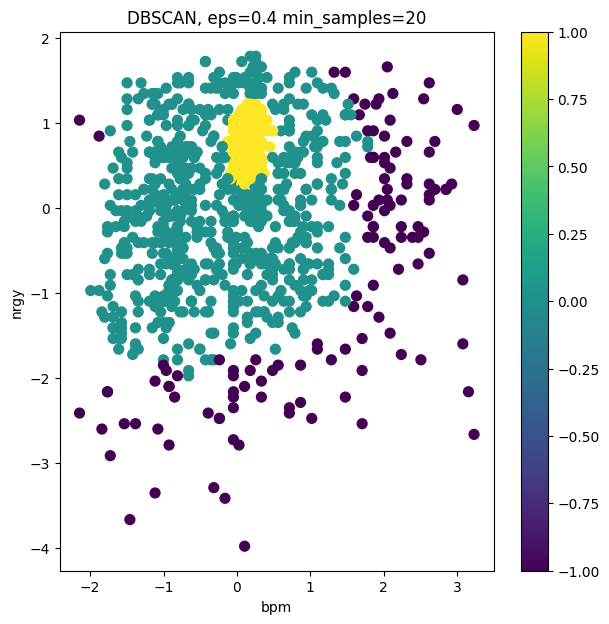

Etykiety (klastry) wykryte przez DBSAN (-1 to szum):  [-1  0  1]
Silhouette Score: 0.01341328389263511


In [137]:
f_dbscan(0.1,20)
f_dbscan(0.1,40)
f_dbscan(0.2,20)
f_dbscan(0.2,40)
f_dbscan(0.4,20)

Dla DBSCAN najwyższą wartość Silhouette Score to 0.6198714412474725 uzyskana dla zmiennych eps = 0.2 i min_samples = 20.

Jest to najlepszy wynik w całym projekcie.